# Calculating the FID Scores

In [1]:
# Import packages
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.stats import linregress
import time
import torchvision.utils

import importlib
import data
import helpers
import unet
import cloud_diffusion as cd

from helpers import fft
from helpers import ifft

from IPython.display import clear_output

In [2]:
# Uncomment and run these when making changes to .py files that require reloading modules
# Can also restart kernel, but this allows for reloading without running everything again
importlib.reload(data)
importlib.reload(helpers)
importlib.reload(unet)
importlib.reload(cd)

from helpers import fft
from helpers import ifft

In [5]:
def get_filter_lists(dataset, short_edge=1, long_edge=32, batch_size=64):
    """
    Builds two lists of integers representing the index of images in the dataset
      clean_list: indices of images with no letterboxes
      dirt_list: indices of images with letterboxes
    Clips the clean_list so that it is divisible by the batch size
    """
    horizontal_pool = torch.nn.AvgPool2d(kernel_size=(short_edge, long_edge), stride=(1, 1))
    vertical_pool = torch.nn.AvgPool2d(kernel_size=(long_edge, short_edge), stride=(1, 1))
    
    def has_vertical_bars(x):
        y = vertical_pool(x)
        if y.min() == 0.0 or y.max() == 1.0:
            return True
        else:
            return False
        
    def has_horizontal_bars(x):
        y = horizontal_pool(x)
        if y.min() == 0.0 or y.max() == 1.0:
            return True
        else:
            return False
    
    clean_list = []
    dirty_list = []
    
    for i in range(len(dataset)):
        image, _ = dataset[i]
        
        if has_vertical_bars(image) or has_horizontal_bars(image):
            dirty_list.append(i)
        else:
            clean_list.append(i)
    
    c = len(clean_list)
    d = len(dirty_list)
    
    print(f"{d}/{c+d} images ({100 * d/(d+c)}%), moved to dirty dataset.")
    
    clean_list = clean_list[0:c//batch_size * batch_size]
    
    print(f"Clean list clipped to {len(clean_list)} images so it is divisible by batch_size={batch_size}.")
    
    return clean_list, dirty_list

In [6]:
def get_datasets(batch_size=64):
    
    # Applies minimal transformations to STL10 data
    # Preserves 96x96 size but converts to grayscale
    minimal_transforms = transforms.Compose([transforms.ToTensor()])
    
    base_dataset = datasets.STL10(root='data', download=True, transform=minimal_transforms, split="unlabeled")
    clean_list, dirty_list = get_filter_lists(base_dataset, batch_size=batch_size)
    
    clean_dataset = torch.utils.data.Subset(base_dataset, clean_list)
    dirty_dataset = torch.utils.data.Subset(base_dataset, dirty_list)
    
    return clean_dataset, dirty_dataset

In [7]:
clean_dataset = get_datasets()[0]

Files already downloaded and verified
37886/100000 images (37.886%), moved to dirty dataset.
Clean list clipped to 62080 images so it is divisible by batch_size=64.


In [8]:
dataloader = torch.utils.data.DataLoader(clean_dataset, batch_size=64, shuffle=True, num_workers=4)

In [8]:
mu_clean, std_clean = helpers.get_mu_and_std(clean_dataset)
mu_clean = mu_clean.to("mps")
std_clean = std_clean.to("mps")

In [9]:
print(mu_clean.shape)
print(std_clean.shape)

torch.Size([3, 96, 96])
torch.Size([3, 96, 96])


In [10]:
def normalize(x, mu, std, device="mps"):
    return (x-mu.to(device))/std.to(device)

In [11]:
def denormalize(x, mu, std, device="mps"):
    return x*std.to(device) + mu.to(device)

In [12]:
data_iter = iter(dataloader)
sigma_clean = torch.zeros(3,48,48,3,48,48, device="mps")
avgpool = torch.nn.AvgPool2d(kernel_size=2, stride=2)
n=0

for i in range(len(data_iter)):
    batch_clean = next(data_iter)[0].to("mps")
    batch_clean = normalize(batch_clean, mu_clean, std_clean)
    small_batch_clean = avgpool(batch_clean)
    
    _sigma_clean = torch.einsum("bcij,bCKL->cijCKL", small_batch_clean, small_batch_clean)
    sigma_clean = (sigma_clean*n + _sigma_clean)/(n+64)
    
    n+=64
    
del data_iter

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


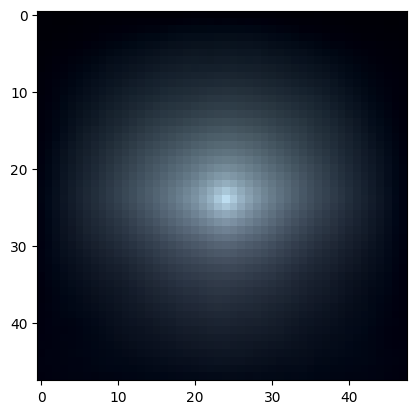

In [13]:
c=2
i=24
j=24
plt.imshow(torch.movedim(sigma_clean.to("cpu")[...,c,i,j], (0,1,2),(2,0,1)))
plt.show()

In [105]:
Sigma_diag = torch.zeros(3,3,96,96, device="mps")
for n in range(len(clean_dataset)):
    x = normalize(clean_dataset[n][0].to("mps"), mu_clean, std_clean)
    _Sigma_diag = torch.einsum("cij,Cij->cCij", x, x)
    Sigma_diag = (Sigma_diag*n+_Sigma_diag)/(n+1)

In [106]:
S = Sigma_diag.mean(dim=(2,3))

In [107]:
print(S)

tensor([[1.0000, 0.9136, 0.7839],
        [0.9136, 1.0000, 0.8969],
        [0.7839, 0.8969, 1.0000]], device='mps:0')


In [108]:
L,V = torch.linalg.eig(S.to("cpu"))

In [109]:
print(L.real)
print(V.real)

tensor([2.7308, 0.2167, 0.0526])
tensor([[-0.5705, -0.6800,  0.4607],
        [-0.5947, -0.0449, -0.8027],
        [-0.5665,  0.7319,  0.3787]])


In [110]:
L = L.real
V = V.real

In [111]:
V_inverse = torch.inverse(V)
print(V_inverse)

tensor([[-0.5705, -0.5947, -0.5665],
        [-0.6800, -0.0449,  0.7319],
        [ 0.4607, -0.8027,  0.3787]])


In [185]:
noise_generator = helpers.NoiseGenerator(96)

In [113]:
color_noise = torch.zeros(64, 3, 96, 96)
for i in range(3):
    color_noise[:,i,:,:] = torch.sqrt(L[i]) * noise_generator.generate_noise_2(Delta=1.4999373536194076, 
                                                                             A=0.10369835607741062, 
                                                                             batch_size=64, 
                                                                             color_channels=1
                                                                            )[0].real.squeeze()

In [114]:
color_noise = torch.einsum("cC,bCij->bcij", V, color_noise)

In [115]:
cn_mean = color_noise.mean(dim=0)
cn_std_squared = torch.mean((color_noise-cn_mean)**2, dim=0)
print(cn_mean.mean(), torch.sqrt(cn_std_squared.mean()))

tensor(-0.2484) tensor(0.9983)


In [116]:
print(color_noise.shape)

torch.Size([64, 3, 96, 96])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 96, 96])


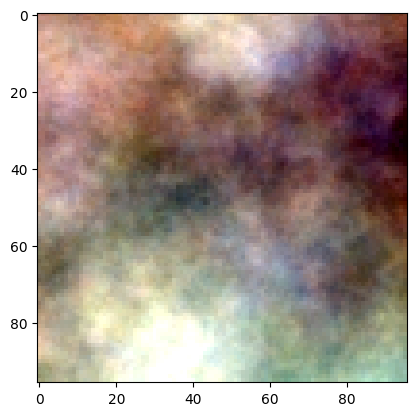

In [174]:
i = np.random.randint(64)
cn = denormalize(color_noise[i], mu=mu_clean, std=std_clean, device="cpu").squeeze()
print(cn.shape)
plt.imshow(torch.movedim(cn, (0,1,2),(2,0,1)))
plt.show()

In [187]:
eigs = torch.linalg.eig(S.to("cpu"))
z, Z = noise_generator.generate_color_noise(Delta=1.4999373536194076, A=0.10369835607741062, eigs=eigs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


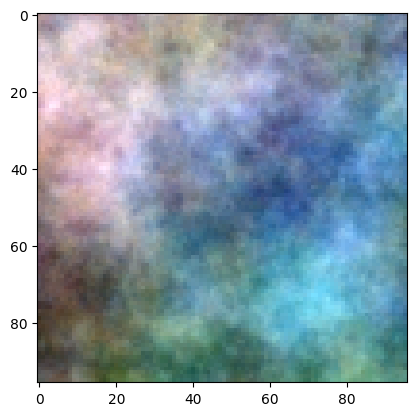

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


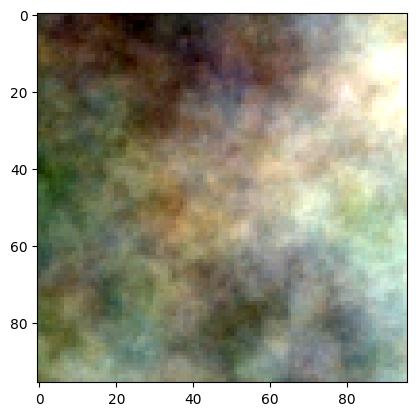

In [250]:
i = np.random.randint(64)

plt.imshow(torch.movedim(denormalize(z[i].real, mu_clean, std_clean, device="cpu"), (0,1,2), (2,0,1)))
plt.show()

plt.imshow(torch.movedim(denormalize(z[i].imag, mu_clean, std_clean, device="cpu"), (0,1,2), (2,0,1)))
plt.show()

In [ ]:
mu_white = torch.zeros(96,96, device="mps")
mu_cloud = torch.zeros(96,96, device="mps")
n=0

for i in range(1,101):
    batch_white = denormalize(torch.load(f"Images/new_white_model/generated_tensor_{i}.pt").squeeze().to("mps"))
    batch_cloud = denormalize(torch.load(f"Images/new_cloud_model_5/generated_tensor_{i}.pt").squeeze().to("mps"))
    
    _mu_white = batch_white.sum(dim=0, keepdim=False)
    _mu_cloud = batch_cloud.sum(dim=0, keepdim=False)
    
    mu_white = (mu_white*n + _mu_white)/(n+64)
    mu_cloud = (mu_cloud*n + _mu_cloud)/(n+64)
    
    del _mu_white
    del _mu_cloud
    
    n+=64

In [ ]:
z, Z = noise_generator.generate_noise_2(Delta=1.4999373536194076, 
                                        A=0.10369835607741062, 
                                        batch_size=64, 
                                        color_channels=3,
                                        eigs=(L,V)
                                       )

In [ ]:
plt.imshow(mu_clean.to("cpu"), vmin=0, vmax=1)
plt.show()

plt.imshow(mu_white.to("cpu"), vmin=0, vmax=1)
plt.show()

plt.imshow(mu_cloud.to("cpu"), vmin=0, vmax=1)
plt.show()

In [ ]:
sigma_white = torch.zeros(96,96,96,96, device="mps")
sigma_cloud = torch.zeros(96,96,96,96, device="mps")
n=0

for i in range(1,101):
    batch_white = denormalize(torch.load(f"Images/new_white_model/generated_tensor_{i}.pt").squeeze().to("mps"))
    batch_cloud = denormalize(torch.load(f"Images/new_cloud_model_5/generated_tensor_{i}.pt").squeeze().to("mps"))
    
    _sigma_white = torch.einsum("bij,bkl->ijkl", batch_white-mu_white, batch_white-mu_white)
    _sigma_cloud = torch.einsum("bij,bkl->ijkl", batch_cloud-mu_cloud, batch_cloud-mu_cloud)
    
    sigma_white = (sigma_white*n + _sigma_white)/(n+64)
    sigma_cloud = (sigma_cloud*n + _sigma_cloud)/(n+64)
    
    del _sigma_white
    del _sigma_cloud
    
    
    n+=64

In [ ]:
k=48
l=48

plt.imshow(sigma_clean[:,:,k,l].to("cpu"), vmin=0, vmax=.04)
plt.show()

plt.imshow(sigma_white[:,:,k,l].to("cpu"), vmin=0, vmax=.04)
plt.show()

plt.imshow(sigma_cloud[:,:,k,l].to("cpu"), vmin=0, vmax=.04)
plt.show()

In [ ]:
sigma_clean_diag = torch.einsum("ijij->ij", sigma_clean)
sigma_white_diag = torch.einsum("ijij->ij", sigma_white)
sigma_cloud_diag = torch.einsum("ijij->ij", sigma_cloud)

In [ ]:
plt.imshow(sigma_clean_diag.to("cpu"))
plt.show()

plt.imshow(sigma_white_diag.to("cpu"))
plt.show()

plt.imshow(sigma_cloud_diag.to("cpu"))
plt.show()

In [ ]:
def FID(mu1, sigma1, mu2, sigma2):
    mu_mu_term = torch.einsum("ij,ij", mu1-mu2, mu1-mu2)
    
    sigma1_flat = torch.flatten(torch.flatten(sigma1, start_dim=0, end_dim=1), start_dim=1)
    sigma2_flat = torch.flatten(torch.flatten(sigma2, start_dim=0, end_dim=1), start_dim=1)
    
    trace_sigmas_term = torch.einsum("ii", sigma1_flat+sigma2_flat)
    
    sig_sig = torch.einsum("ik,kj->ij", sigma1_flat, sigma2_flat)
    
    eigs = torch.linalg.eigvals(sig_sig.to("cpu")).real
    eigs = torch.where(eigs<0, 0, eigs).to("mps")
    
    sig_sig_term = -2*torch.sum(torch.sqrt(eigs))
    
    return mu_mu_term + trace_sigmas_term + sig_sig_term

In [ ]:
FID(mu_clean, sigma_clean, mu_clean, sigma_clean)

In [ ]:
FID(mu_clean, sigma_clean, mu_white, sigma_white)

In [ ]:
FID(mu_white, sigma_white, mu_clean, sigma_clean)

In [ ]:
FID(mu_clean, sigma_clean, mu_cloud, sigma_cloud)

In [ ]:
FID(mu_cloud, sigma_cloud, mu_clean, sigma_clean)

In [ ]:
FID(mu_cloud, sigma_cloud, mu_cloud, sigma_cloud)

### Sigma tensor and inverse for color noise

In [9]:
mu = torch.zeros(3*96*96, device="mps")
Sigma = torch.zeros(3*96*96, 3*96*96, device="mps")

In [10]:
for n in range(len(clean_dataset)):
    x = torch.flatten(clean_dataset[n][0].to("mps"))
    mu = (mu*n + x)/(n+1)
    
    if n%1000==0: 
        clear_output()
        print(f"{100* n/len(clean_dataset)}% complete")

99.87113402061856% complete


In [13]:
t0 = time.time()
for n in range(len(clean_dataset)):
    x = torch.flatten(clean_dataset[n][0].to("mps"))-mu
    Sigma = (Sigma*n + torch.outer(x, x))/(n+1)
    
    if n%10==0: 
        clear_output()
        print(f"{100* n/len(clean_dataset)}% complete || Time elapsed = {(time.time()-t0)/60} minutes")

0.04832474226804124% complete || Time elapsed = 3.724018983046214 minutes


KeyboardInterrupt: 